## Set-up environment

In [ ]:
!pip install -q datasets

## Load the image captioning dataset

In [1]:
from datasets import load_dataset

ds_main = load_dataset("jmhessel/newyorker_caption_contest", "explanation", split="train")

README.md:   0%|          | 0.00/40.2k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/125M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/7.97M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/6.80M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2340 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/130 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/131 [00:00<?, ? examples/s]

# Part $1:$ Data Analysis and Preparation

In [2]:
ds_main.features

{'image': Image(mode=None, decode=True, id=None),
 'contest_number': Value(dtype='int32', id=None),
 'image_location': Value(dtype='string', id=None),
 'image_description': Value(dtype='string', id=None),
 'image_uncanny_description': Value(dtype='string', id=None),
 'entities': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'questions': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'caption_choices': Value(dtype='string', id=None),
 'from_description': Value(dtype='string', id=None),
 'label': Value(dtype='string', id=None),
 'n_tokens_label': Value(dtype='int32', id=None),
 'instance_id': Value(dtype='string', id=None)}

In [3]:
def check_missing():
    for feature in ds_main.features:
        values = ds_main[feature]
        missing = sum(v is None or v == "" for v in values)
        print(f"{feature}: {missing} missing")

check_missing()

image: 0 missing
contest_number: 0 missing
image_location: 0 missing
image_description: 0 missing
image_uncanny_description: 0 missing
entities: 0 missing
questions: 0 missing
caption_choices: 0 missing
from_description: 0 missing
label: 0 missing
n_tokens_label: 0 missing
instance_id: 0 missing


No missing value in any column

In [4]:
df = ds_main.to_pandas()

df.head()

,image,contest_number,image_location,image_description,image_uncanny_description,entities,questions,caption_choices,from_description,label,n_tokens_label,instance_id
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,130,the yard,Two women are looking out a window. There is s...,"A snowman has branches for arms, not human arms.","[https://en.wikipedia.org/wiki/Snowman, https:...",[Is there a man stuck inside?],He has a summer job as a scarecrow.,scene: the yard description: Two women are loo...,The real man inside of the snowman is apparent...,60,62ccf347365fcaad455f9d11267ce10a
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,338,a residential home,A man and a woman are in a room with a regular...,It is unusual to see such a giant book.,"[https://en.wikipedia.org/wiki/Novel, https://...","[Why is the book so big?, What is written in t...",You promised me you would stop after you lost ...,scene: a residential home description: A man a...,The person writing in the giant book only has ...,103,90ec8eabd70643ba4dcbe4c79264a459
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,619,a corporate office,There are two men in suits standing at the doo...,It is unusual for a sword to be sticking out o...,"[https://en.wikipedia.org/wiki/Sword, https://...",[Why is there a sword stuck in an office desk?...,"The pen is mightier, but that looks awesome.",scene: a corporate office description: There a...,"A reference to the saying ""the pen is mightier...",59,d0e7e4deed741964d642361d243f2ecb
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,217,an office room,There is a pool in an office. A man is going t...,There is a huge pool in an office and someone ...,"[https://en.wikipedia.org/wiki/Swimming_pool, ...",[Why is there a pool in an office building?],My wife won't let me put one in the back yard.,scene: an office room description: There is a ...,Couples sometimes argue about whether or not t...,52,351d0ea8e64914291a556dd35bcffdb7
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,711,the living room,3 baseball players appear to be playing baseba...,It's unusual to see games of baseball being pl...,"[https://en.wikipedia.org/wiki/Baseball, https...",[Why are those people playing baseball in a li...,All his pitches have been inside.,scene: the living room description: 3 baseball...,"A play on words. An ""inside pitch"" in baseball...",50,d11cfc0914483e80acfafdb220e9799a


In [5]:
df['caption_choices'].value_counts()

caption_choices
It's curb to table.                                                            6
He has a summer job as a scarecrow.                                            6
You promised me you would stop after you lost your arm from that paper cut!    6
The pen is mightier, but that looks awesome.                                   6
My wife won't let me put one in the back yard.                                 6
                                                                              ..
I'm up here.                                                                   6
I wish they would just go back to tapping our phone lines.                     6
Relax. The DVR is set. You can catch the game tomorrow.                        6
You bought the sofa, you find the remote.                                      6
Look, you agreed to a trial separation.                                        6
Name: count, Length: 390, dtype: int64

Every caption is repeating 6 times. It's also observed that for an image, only caption and label remains the same among all the columns for all the 6 cases. Therefore, the dataset can be reduced to contain only image, caption_choices and label.

**Additional context from the textual features can also help in creating richer embedding and model** but here a baseline prototype has been demonstrated considering time and resource constraints. 

In [5]:
selected_cols = ['caption_choices', 'label']

# Remove duplicates based on those columns
df = df.drop_duplicates(subset=selected_cols)

df.shape

(390, 12)

In [6]:
from datasets import Dataset

ds = Dataset.from_pandas(df[["image", "caption_choices", "label"]])

## Create PyTorch Dataset

In [7]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import io


class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = Image.open(io.BytesIO(item["image"]['bytes']))
        text = item["caption_choices"]
        
        encoding = self.processor(images=image, text=text, padding="max_length", return_tensors="pt")
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

## Load model and processor

In [8]:
MODEL_NAME = "Salesforce/blip-image-captioning-base"

In [9]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained(MODEL_NAME)
model = BlipForConditionalGeneration.from_pretrained(MODEL_NAME)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Now that we have loaded the processor, let's load the dataset and the dataloader:

Given the time and resource constraints, I've fine-tuned on 100 datapoints. Although it could lead to overfitting on the data, I'd at least get comparitevely different captions on different datapoints. 

In [10]:
train_dataset = ImageCaptioningDataset(ds.select(range(100)), processor)
train_dataloader = DataLoader(train_dataset, shuffle=True)

# Part $2$: Exploratory Data Analysis (EDA)

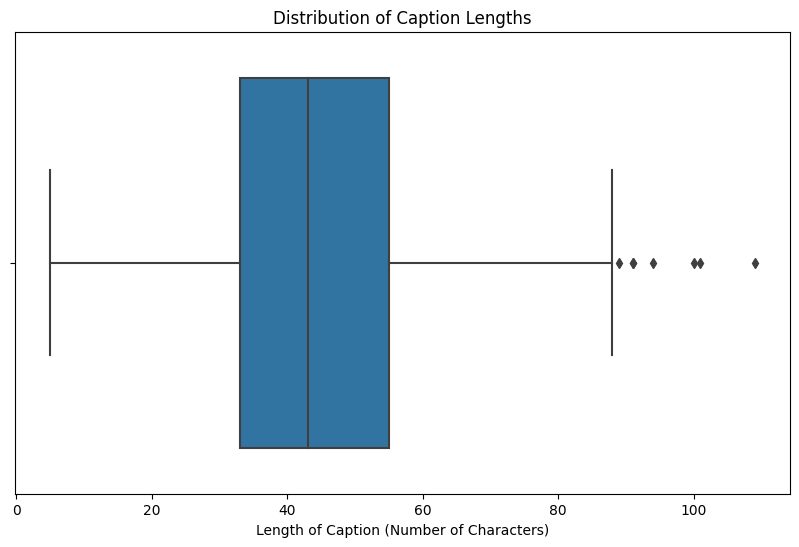

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Assuming df["caption_choices"] contains strings (single captions) ---
# Calculate lengths
caption_lengths = df['caption_choices'].str.len()

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=caption_lengths)
plt.title('Distribution of Caption Lengths')
plt.xlabel('Length of Caption (Number of Characters)')
plt.show()


max_length of generated caption can be anywhere between 50 to 70.

In [12]:
import pandas as pd
from collections import Counter
from transformers import AutoTokenizer # Use AutoTokenizer to load various model tokenizers

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

all_captions = df['caption_choices'].astype(str).tolist()

# --- Tokenize the text ---
# You can tokenize all captions at once or iterate
all_tokens = []
for caption in all_captions:
  tokens = tokenizer.tokenize(caption)
  all_tokens.extend(tokens)


# --- Analyze the Vocabulary ---

token_counts = Counter(all_tokens)

print(f"--- Vocabulary Analysis using '{tokenizer_name}' Tokenizer ---")

print("\nMost common tokens:")
print(token_counts.most_common(30)) # Show top 30 tokens

vocab_size = tokenizer.vocab_size

print(f"\nTokenizer's predefined vocabulary size: {vocab_size}")
print(f"\nNumber of unique tokens found in our captions: {len(token_counts)}")

# Check for unknown tokens (less common with subword tokenizers,
# but good practice). The default 'unk_token' is often '[UNK]'
unknown_token = tokenizer.unk_token
if unknown_token in token_counts:
    print(f"\nFound '{unknown_token}' token {token_counts[unknown_token]} times.")
else:
    print(f"\nDid not find the default unknown token ('{unknown_token}') in the captions.")

--- Vocabulary Analysis using 'Salesforce/blip-image-captioning-base' Tokenizer ---

Most common tokens:
[('.', 372), ("'", 185), ('the', 155), ('i', 148), ('you', 133), (',', 130), ('a', 86), ('to', 77), ('s', 65), ('it', 64), ('?', 60), ('t', 53), ('this', 41), ('is', 40), ('in', 40), ('on', 39), ('your', 35), ('we', 35), ('of', 34), ('m', 32), ('for', 30), ('!', 29), ('just', 29), ('can', 29), ('have', 28), ('-', 28), ('that', 27), ('and', 27), ('re', 24), ('my', 23)]

Tokenizer's predefined vocabulary size: 30522

Number of unique tokens found in our captions: 1263

Did not find the default unknown token ('[UNK]') in the captions.


EDA suggested us to take following actions:

1. Images have not been preprocessed or normalized because the BLIP model was trained on 224 × 224 images during pre-training, and increased the image resolution to 384 × 384 during finetuning. Therefore, I abstained from resizing them.
2. Images are black & white, so it's important to not reduce their quality.
3. Captions are usual english sentences with not a single UNK token, therefore the default tokenization techniques should work as usual.
4. Looking at the caption length distribution, max_length can be set to 50 so that model learns to generalize and doesn't simply overfit on associated captions.
5. Captions have 1263 unique words, whereas our dataset is limited. Therefore the model is likely to not generalize better. We'll require more data for a model to generalize.

# Part $3$: Model Development

Let's train the model! Run the simply the cell below for training the model

In [11]:
len(train_dataset)

100

In [13]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device)

model.train()

for epoch in range(20):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)
    attention_mask = batch.pop('attention_mask').to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    attention_mask=attention_mask,
                    labels=input_ids)

    loss = outputs.loss

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
  print(f"Loss: {loss}")

cuda
Epoch: 0
Loss: 0.23275667428970337
Epoch: 1
Loss: 0.11931715160608292
Epoch: 2
Loss: 0.06521792709827423
Epoch: 3
Loss: 0.054304372519254684
Epoch: 4
Loss: 0.02339538000524044
Epoch: 5
Loss: 0.038039401173591614
Epoch: 6
Loss: 0.015488550998270512
Epoch: 7
Loss: 0.01772310398519039
Epoch: 8
Loss: 0.015834568068385124
Epoch: 9
Loss: 0.013411978259682655
Epoch: 10
Loss: 0.015001395717263222
Epoch: 11
Loss: 0.011640053242444992
Epoch: 12
Loss: 0.012118491344153881
Epoch: 13
Loss: 0.012125461362302303
Epoch: 14
Loss: 0.009546211920678616
Epoch: 15
Loss: 0.011456949636340141
Epoch: 16
Loss: 0.012187175452709198
Epoch: 17
Loss: 0.013831089250743389
Epoch: 18
Loss: 0.04057234525680542
Epoch: 19
Loss: 0.022890901193022728


Let's check the results on our train dataset

# Part $4$: Model Evaluation

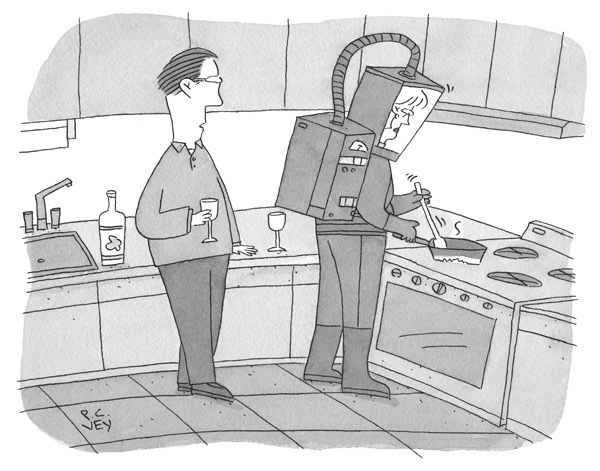

In [27]:
# load image
example = ds[127]
image = Image.open(io.BytesIO(example["image"]['bytes']))
image

In [28]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

i can ' t believe my eye!


We are going to consider other columns' information as references to compare against the models' generative capability.

In [18]:
print (ds_main["image_description"][0])
print (ds_main["caption_choices"][0])
print (ds_main["label"][0])

Two women are looking out a window. There is snow outside, and there is a snowman with human arms.
He has a summer job as a scarecrow.
The real man inside of the snowman is apparently the sort of person who will take a seasonal job as a seasonally-appropriate anthropomorphic sculpture, e.g., a snowman in winter, or a scarecrow in the summer. It's funny because this isn't a real job, and even if it was, the type of person who would accept it is very odd.


In [19]:
candidates = []
references = []

# --- Iterate through dataset and generate captions ---
print(f"Generating captions for samples...")
for item in ds_main.select(range(150, 250)):
    image = item["image"]
    
    # --- Generate Caption (Candidate) ---

    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    with torch.no_grad(): # Ensure no gradients are calculated during inference
        generated_ids = model.generate(pixel_values=pixel_values, max_length=50)

    # Decode generated IDs to text, skipping special tokens
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    candidates.append(generated_caption)

    # --- Collect References ---
    
    ref_list = [item['image_description']]
    ref_list += [item['caption_choices']]
    ref_list += [item['label']]

    references.append(ref_list)
    

Generating captions for 2340 samples...


In [20]:
len(candidates), len(references)

(100, 100)

In [21]:
! pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.9 MB/s eta 0:00:00


In [22]:
import bert_score

# --- Calculate BERTScore ---

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Calculate scores (Precision, Recall, F1)
# lang="en" is important for English text
P, R, F1 = bert_score.score(
    cands=candidates,
    refs=references,
    lang="en",   
    verbose=True,    
    device=device,  
)

# --- Process and Print Results ---

# F1 scores are often the primary metric reported
print("\n--- BERTScore Results ---")
print(f"Precision Scores: {P}")
print(f"Recall Scores: {R}")
print(f"F1 Scores: {F1}")

# Calculate the average F1 score across all candidates
average_f1 = F1.mean().item() # .item() gets the scalar value from the tensor
print(f"\nAverage F1 Score: {average_f1:.4f}")

# Interpretation:
# - Scores range roughly between 0 and 1 (though can slightly exceed 1 with certain models). Higher is better.
# - Precision: How much of the generated caption is relevant/semantically similar to the references?
# - Recall: How much of the reference captions' meaning is captured by the generated caption?
# - F1: The harmonic mean of Precision and Recall.

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/5 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/5 [00:00<?, ?it/s]

done in 2.57 seconds, 116.79 sentences/sec

--- BERTScore Results ---
Precision Scores: tensor([0.8289, 0.8376, 0.8414, 0.7992, 0.8387, 0.8364, 0.9666, 0.8455, 0.8349,
        0.8382, 0.8074, 0.9985, 0.9344, 0.8423, 0.7931, 0.7849, 0.8690, 0.8304,
        0.8319, 0.8356, 0.8285, 0.8097, 0.8707, 0.8077, 0.8282, 0.8499, 0.8315,
        0.8303, 0.8387, 0.8106, 0.8364, 0.7981, 0.7864, 0.8266, 0.8287, 0.8656,
        0.8393, 0.8029, 0.8540, 0.8388, 0.8243, 0.8571, 0.8286, 0.8546, 0.7893,
        0.8401, 0.8358, 0.7849, 0.7876, 0.8029, 0.8316, 0.8335, 0.8514, 0.8327,
        0.7887, 0.8378, 0.7877, 0.8393, 0.8317, 0.8265, 0.7895, 0.8278, 0.7893,
        0.8181, 0.8185, 0.7981, 0.7908, 0.8274, 0.7832, 0.8261, 0.8513, 0.8245,
        0.8302, 0.7933, 0.8266, 0.7885, 0.8299, 0.8173, 0.8378, 0.8551, 0.8300,
        0.8282, 0.8320, 0.8322, 0.8515, 0.8236, 0.8291, 0.7883, 0.8407, 0.8446,
        0.7847, 0.8215, 0.7893, 0.7962, 0.8239, 0.8287, 0.8246, 0.8295, 0.8191,
        0.8656])
Recall Scores: 

That's a big number. It's better to cross-verify.

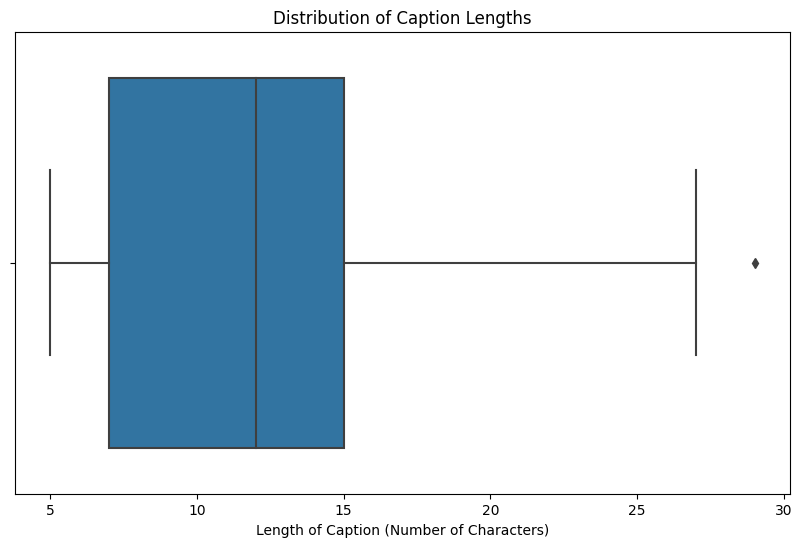

In [31]:
# Check data distribution of generated captions.

caption_lengths = [len(sentence.split()) for sentence in candidates]
# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=caption_lengths)
plt.title('Distribution of Caption Lengths')
plt.xlabel('Length of Caption (Number of Characters)')
plt.show()

The fine-tuned checkpoint model seems to give decent results on unseen data. Sanity checks on some data points also explains that. But without propoer linguistic analysis it shouldn't be confirmed especially when the generated captions are of short length. Small captions can inflate the metrics.

## Save & Load from the Hub

Once trained you can push the model and processor on the Hub to use them later.
Meanwhile you can play with the model that we have fine-tuned!

In [ ]:

from huggingface_hub import notebook_login

notebook_login()

In [30]:
repo_name = "ny-image-captioning"

model.push_to_hub(repo_name)
processor.push_to_hub(repo_name)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/RSRathore/ny-image-captioning/commit/66cf0a79db5ef79028153e01e1423e45f42343ca', commit_message='Upload processor', commit_description='', oid='66cf0a79db5ef79028153e01e1423e45f42343ca', pr_url=None, repo_url=RepoUrl('https://huggingface.co/RSRathore/ny-image-captioning', endpoint='https://huggingface.co', repo_type='model', repo_id='RSRathore/ny-image-captioning'), pr_revision=None, pr_num=None)

In [67]:
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("RSRathore/ny-image-captioning")
model = AutoModelForImageTextToText.from_pretrained("RSRathore/ny-image-captioning")

preprocessor_config.json:   0%|          | 0.00/431 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

Let's check the results on our train dataset!

In [70]:
model.to(device)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

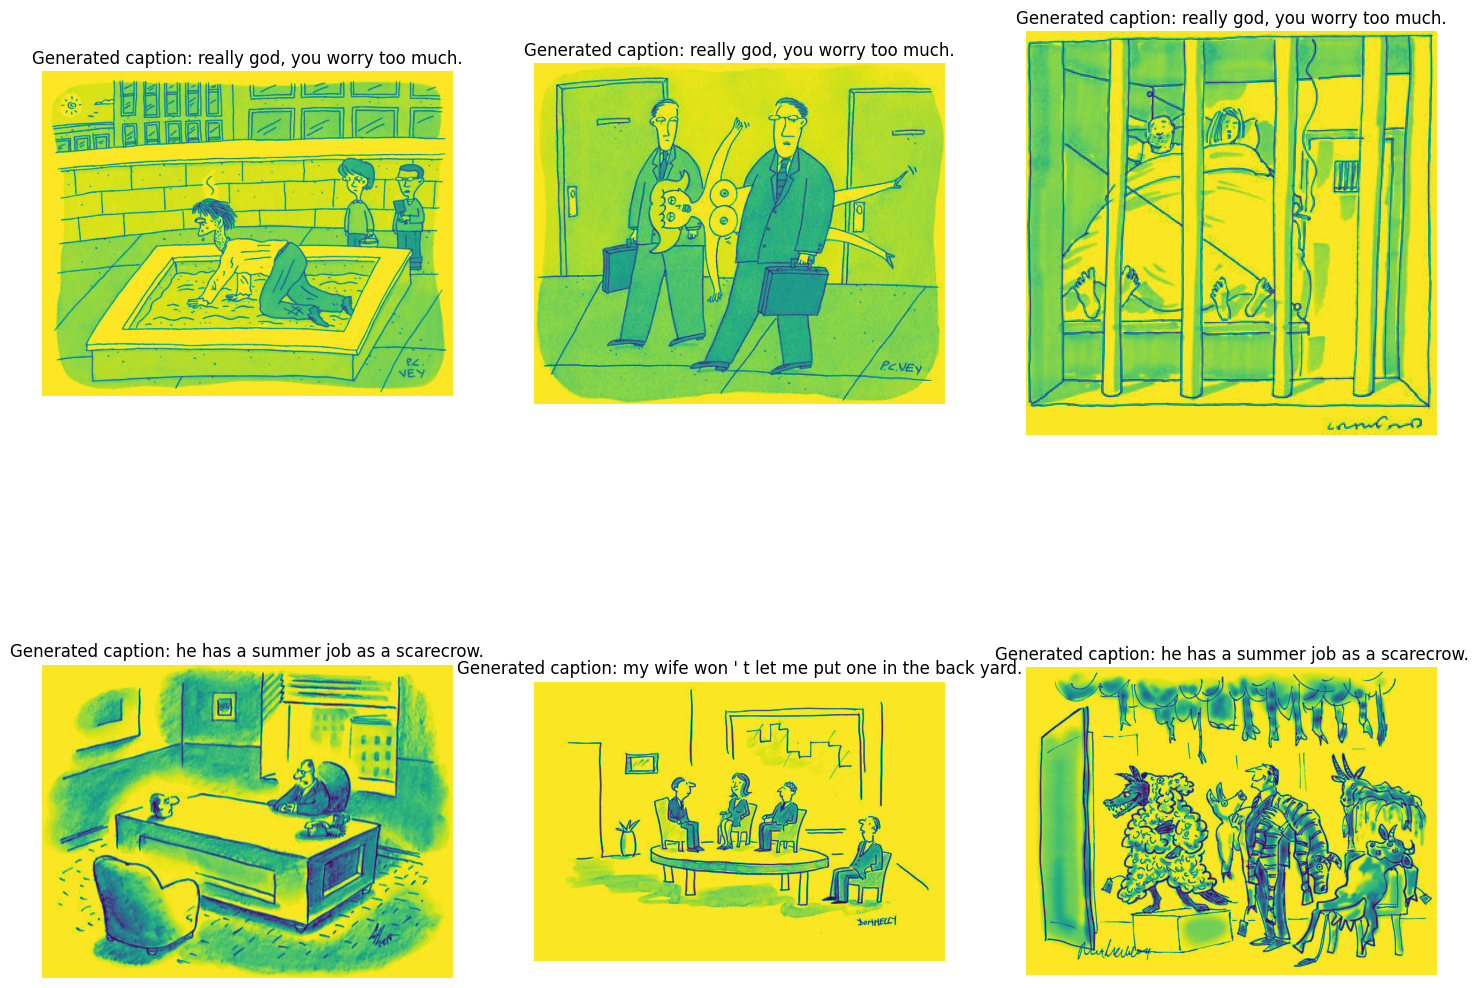

In [73]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(ds.select(range(6))):
  image = Image.open(io.BytesIO(example["image"]['bytes']))
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")